In [2]:
import pandas as pd
import os

parent_dir = os.path.dirname(os.getcwd())
train = pd.read_csv(parent_dir + '/dm2_dataset_2425_imdb/train70_clf.csv')
test = pd.read_csv(parent_dir + '/dm2_dataset_2425_imdb/test30_clf.csv')

In [3]:
# Drop observations where titleType is 'videoGame'
train = train[train['titleType'] != 'videoGame']
test = test[test['titleType'] != 'videoGame']

# Define a mapping dictionary for titleType
titletype_mapping = {
    'movie': 'movie',
    'tvMovie': 'movie',
    'short': 'short',
    'tvShort': 'short',
    'tvSeries': 'tvSeries',
    'tvMiniSeries': 'tvSeries',
    'tvEpisode': 'tvEpisode',
    'tvSpecial': 'tvSpecial',
    'video': 'video'
}

# Apply the mapping to the titleType column
train['titleType'] = train['titleType'].map(titletype_mapping)
test['titleType'] = test['titleType'].map(titletype_mapping)

# Check the new unique values
print("New unique values in titleType:", train['titleType'].unique())

New unique values in titleType: ['movie' 'short' 'tvEpisode' 'tvSeries' 'video' 'tvSpecial']


In [4]:
X_train = train.drop(columns=['titleType', 'canHaveEpisodes'])
y_train = train['titleType']

X_test = test.drop(columns=['titleType', 'canHaveEpisodes'])
y_test = test['titleType']

In [5]:
from sklearn.preprocessing import LabelEncoder

# One-hot encode y_train for categorical_crossentropy
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
# Log transform skewed features
import numpy as np


to_log = [
       'numRegions', 'ratingCount', 'companiesNumber',
       'totalNominations', 'totalMedia', 'totalReviews',
       'deltaCredits'
]

# Apply log transformation safely (fill NaN, clip negatives)
for col in to_log:
    X_train[col] = np.log1p(X_train[col].fillna(0).clip(lower=0))
    X_test[col] = np.log1p(X_test[col].fillna(0).clip(lower=0))

In [6]:
# Preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Random Forest

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier

# Define search space for hyperparameters
search_map_rf = {
    'n_estimators': randint(10, 100),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy'],
    'max_features': uniform(0.1, 0.9),
    'class_weight': ['balanced', 'balanced_subsample', None],
}

# Set up cross-validation strategy
cv_rf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

# Create RandomForestClassifier for search
search_model_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Randomized search
random_search_rf = RandomizedSearchCV(
    estimator=search_model_rf,
    param_distributions=search_map_rf,
    n_iter=200,
    scoring='f1_micro',
    cv=cv_rf,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_rf.fit(X_train, y_train)
best_model_rf = random_search_rf.best_estimator_
print("Best parameters found for Random Forest:", random_search_rf.best_params_)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found for Random Forest: {'class_weight': None, 'criterion': 'gini', 'max_depth': 19, 'max_features': 0.7361716094628554, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 42}


In [8]:
# from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
# from scipy.stats import randint, uniform
# from sklearn.ensemble import RandomForestClassifier

# best_params = {'class_weight': None, 'criterion': 'gini', 'max_depth': 19, 'max_features': 0.7361716094628554, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 42}

# # Train the model using the best parameters
# best_model_rf = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
# best_model_rf.fit(X_train, y_train)

              precision    recall  f1-score   support

       movie       0.91      0.95      0.93     12947
       short       0.93      0.96      0.95      4994
   tvEpisode       0.96      0.98      0.97     21249
    tvSeries       0.77      0.70      0.73      3247
   tvSpecial       0.69      0.26      0.38       345
       video       0.77      0.42      0.55      1545

    accuracy                           0.92     44327
   macro avg       0.84      0.71      0.75     44327
weighted avg       0.92      0.92      0.92     44327



<Figure size 400x400 with 0 Axes>

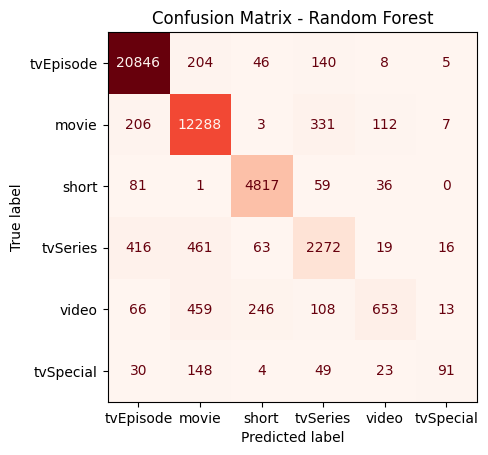

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix


# Predict on the test set
y_pred = best_model_rf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Sort confusion matrix by support
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
support = [report[label]['support'] for label in le.classes_]
sorted_indices = sorted(range(len(support)), key=lambda k: support[k], reverse=True)
sorted_labels = [le.classes_[i] for i in sorted_indices]

plt.figure(figsize=(4, 4))

# 1. Manually create the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)))

# 2. Sort the confusion matrix based on the sorted_indices
cm_sorted = cm[sorted_indices, :]  # Sort rows
cm_sorted = cm_sorted[:, sorted_indices] # Sort columns

# 3. Create a new ConfusionMatrixDisplay object with the sorted matrix and sorted labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sorted, display_labels=sorted_labels)
# disp.xticks_rotation = 45

# 4. Plot the sorted confusion matrix
disp.plot(cmap='Reds', colorbar=False)

plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title('Confusion Matrix - Random Forest')
plt.show()

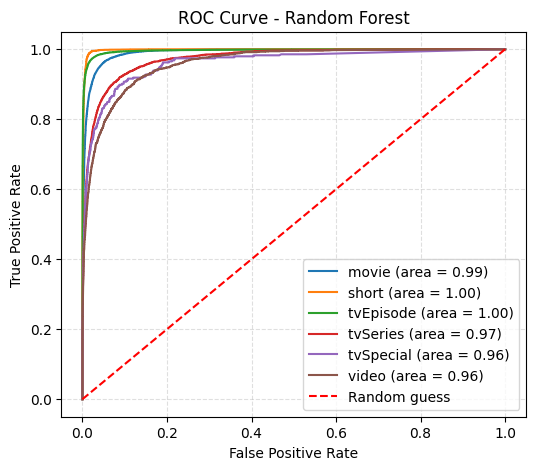

In [10]:
# ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve for each rating bin
fpr = {}
tpr = {}
roc_auc = {}
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, best_model_rf.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(6, 5))
for i in range(6):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(le.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.title('ROC Curve - Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(linestyle='--', alpha=0.4)
plt.show()

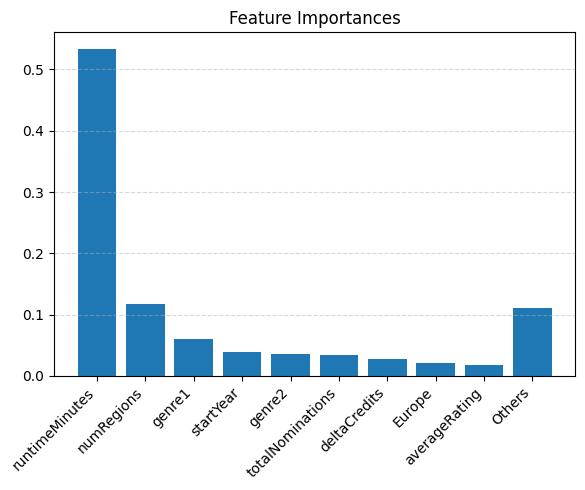

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Compute top 9 feature importances and sum of the rest
top_n = 9
top_indices = np.argsort(best_model_rf.feature_importances_)[::-1][:top_n]
rest_importance = best_model_rf.feature_importances_[np.argsort(best_model_rf.feature_importances_)[::-1][top_n:]].sum()
plot_importances = np.concatenate([best_model_rf.feature_importances_[top_indices], [rest_importance]])
plot_names = list(scaler.get_feature_names_out()[top_indices]) + ['Others']

# Get feature importances from the best_model_rf
# importances = best_model_rf.feature_importances_
# indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(6, 5))
plt.title("Feature Importances")
plt.bar(range(len(plot_importances)), plot_importances, align='center')
# Get column names from scaler
column_names = scaler.get_feature_names_out()
# Sort column names according to indices
column_names = np.array(column_names)[top_indices].tolist() + ['Others']

plt.xticks(range(len(plot_importances)), plot_names, rotation=45, ha='right')
# plt.xlim([-1, X_train.shape[1]])
plt.grid(alpha=0.5, linestyle='--', axis='y')
plt.tight_layout()
plt.show()

# Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Define search space for hyperparameters
search_map_ab = {
    'n_estimators': randint(10, 100),
    'learning_rate': uniform(0.01, 1.0),
    'estimator__max_depth': randint(1, 20),
    'estimator__min_samples_split': randint(2, 20),
    'estimator__min_samples_leaf': randint(1, 20),
}

# Set up cross-validation strategy
cv_ab = StratifiedKFold(n_splits=5, n_repeats=2)

# Create AdaBoostClassifier for search
search_model_ab = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(), random_state=42
)

# Randomized search
random_search_ab = RandomizedSearchCV(
    estimator=search_model_ab,
    param_distributions=search_map_ab,
    n_iter=200,
    scoring='accuracy',
    cv=cv_ab,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_ab.fit(X_train, y_train)
best_model_ab = random_search_ab.best_estimator_
print("Best parameters found for AdaBoost:", random_search_ab.best_params_)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

Best parameters found for AdaBoost: {'estimator__max_depth': 14, 'estimator__min_samples_leaf': 18, 'estimator__min_samples_split': 10, 'learning_rate': 0.025966252220214196, 'n_estimators': 11}


In [13]:
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier

# best_params = {'estimator__max_depth': 10, 'estimator__min_samples_leaf': 16, 'estimator__min_samples_split': 16, 'learning_rate': 0.46606998421703594, 'n_estimators': 56}

# # Train the model using the best parameters
# best_model_ab = AdaBoostClassifier(
#     estimator=DecisionTreeClassifier(
#         max_depth=best_params['estimator__max_depth'],
#         min_samples_leaf=best_params['estimator__min_samples_leaf'],
#         min_samples_split=best_params['estimator__min_samples_split'],
#         random_state=42
#     ),
#     learning_rate=best_params['learning_rate'],
#     n_estimators=best_params['n_estimators'],
#     random_state=42
# )
# best_model_ab.fit(X_train, y_train)

              precision    recall  f1-score   support

       movie       0.90      0.95      0.92     12947
       short       0.93      0.97      0.95      4994
   tvEpisode       0.96      0.98      0.97     21249
    tvSeries       0.75      0.69      0.72      3247
   tvSpecial       0.57      0.23      0.32       345
       video       0.75      0.37      0.50      1545

    accuracy                           0.92     44327
   macro avg       0.81      0.70      0.73     44327
weighted avg       0.91      0.92      0.91     44327



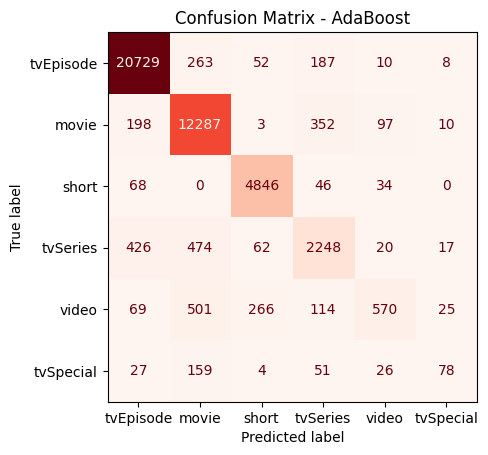

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix


# Predict on the test set
y_pred = best_model_ab.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Sort confusion matrix by support
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
support = [report[label]['support'] for label in le.classes_]
sorted_indices = sorted(range(len(support)), key=lambda k: support[k], reverse=True)
sorted_labels = [le.classes_[i] for i in sorted_indices]

# 1. Manually create the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)))

# 2. Sort the confusion matrix based on the sorted_indices
cm_sorted = cm[sorted_indices, :]  # Sort rows
cm_sorted = cm_sorted[:, sorted_indices] # Sort columns

# 3. Create a new ConfusionMatrixDisplay object with the sorted matrix and sorted labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sorted, display_labels=sorted_labels)
disp.xticks_rotation = 45

# 4. Plot the sorted confusion matrix
disp.plot(cmap='Reds', colorbar=False)

plt.title('Confusion Matrix - AdaBoost')


plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

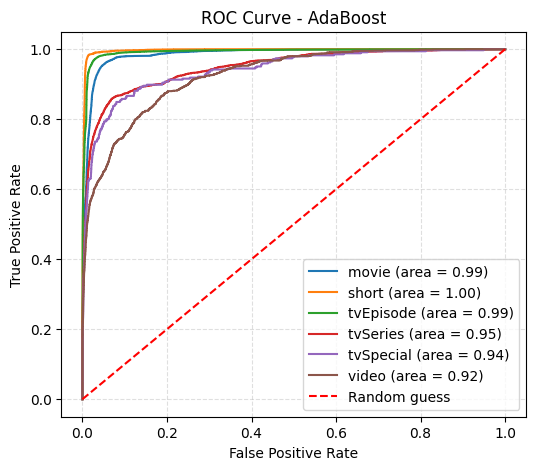

In [15]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve for each rating bin
fpr = {}
tpr = {}
roc_auc = {}
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, best_model_ab.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(6, 5))
for i in range(6):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(le.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.title('ROC Curve - AdaBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(linestyle='--', alpha=0.4)
plt.show()

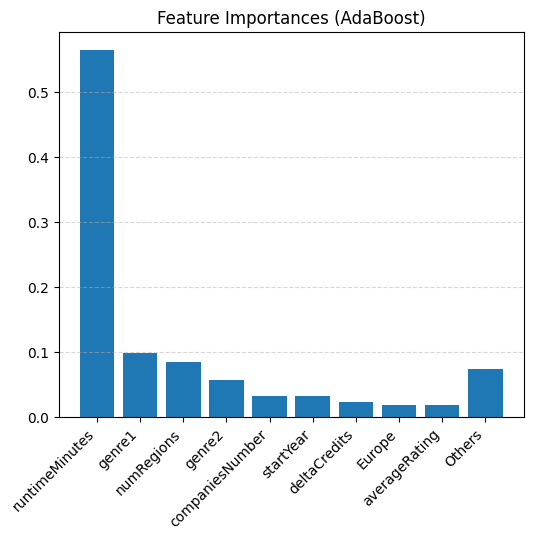

In [16]:
# Feature importances for AdaBoost
# Get feature importances from the best_model_ab
importances_ab = best_model_ab.feature_importances_
indices_ab = np.argsort(importances_ab)[::-1]
# select top 9 features and sum the rest
top_n = 9
top_indices_ab = indices_ab[:top_n]
rest_importance_ab = importances_ab[indices_ab[top_n:]].sum()
importances_ab = np.concatenate([importances_ab[top_indices_ab], [rest_importance_ab]])
# Plot names
plot_names_ab = list(scaler.get_feature_names_out()[top_indices_ab]) + ['Others']

# Plot the feature importances
plt.figure(figsize=(6, 5))
plt.title("Feature Importances (AdaBoost)")
plt.bar(range(len(importances_ab)), importances_ab, align='center')

# Get column names from scaler
column_names_ab = scaler.get_feature_names_out()
# Sort column names according to indices
column_names_ab = np.array(column_names_ab)[top_indices_ab].tolist() + ['Others']
plt.xticks(range(len(importances_ab)), plot_names_ab, rotation=45, ha='right')
plt.grid(alpha=0.5, linestyle='--', axis='y')
plt.show()

# Rating

In [37]:
parent_dir = os.path.dirname(os.getcwd())
train = pd.read_csv(parent_dir + '/dm2_dataset_2425_imdb/train70_clf.csv')
test = pd.read_csv(parent_dir + '/dm2_dataset_2425_imdb/test30_clf.csv')

In [38]:
X_train = train.drop(columns=['averageRating', 'canHaveEpisodes'])
y_train = train['averageRating']

X_test = test.drop(columns=['averageRating', 'canHaveEpisodes'])
y_test = test['averageRating']

# One hot encode the titleType column
X_train = pd.get_dummies(X_train, columns=['titleType'], drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=['titleType'], drop_first=True, dtype=int)

In [39]:
import numpy as np


to_log = [
       'numRegions', 'ratingCount', 'companiesNumber',
       'totalNominations', 'totalMedia', 'totalReviews',
       'deltaCredits'
]

# Apply log transformation safely (fill NaN, clip negatives)
for col in to_log:
    X_train[col] = np.log1p(X_train[col].fillna(0).clip(lower=0))
    X_test[col] = np.log1p(X_test[col].fillna(0).clip(lower=0))

In [40]:
# Preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
# Map values in intervals to new  bins
def remap_rating(rating):
    if rating < 5:
        return 0
    elif 5 <= rating < 6:
        return 1
    elif 6 <= rating < 7:
        return 2
    elif 7 <= rating < 8:
        return 3
    elif 8 <= rating < 9:
        return 4
    else:  # rating >= 9
        return 5

import numpy as np

# Remap y_train and y_test using np.vectorize
y_train = np.vectorize(remap_rating)(y_train)
y_test = np.vectorize(remap_rating)(y_test)

y_train, y_test

(array([2, 2, 3, ..., 4, 1, 3]), array([4, 1, 0, ..., 3, 1, 5]))

# Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from scipy.stats import uniform, randint

# Define the search space for hyperparameters
search_map_rf = {
    'n_estimators': randint(10, 100),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy'],
    'max_features': uniform(0.1, 0.9),
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define the cross-validation strategy
cv_rf = StratifiedKFold(
    n_splits=5
)

In [23]:
from sklearn.model_selection import RandomizedSearchCV

# Set up RandomizedSearchCV for RandomForestClassifier
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=search_map_rf,
    n_iter=200,
    scoring='f1_micro',
    cv=cv_rf,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_rf.fit(X_train, y_train)
best_model_rf = random_search_rf.best_estimator_
print("Best parameters found for Random Forest:", random_search_rf.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found for Random Forest: {'class_weight': None, 'criterion': 'gini', 'max_depth': 19, 'max_features': 0.9137428250443735, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 97}


In [24]:
# # train the model using the best parameters
# best_params = {'class_weight': None, 'criterion': 'gini', 'max_depth': 19, 'max_features': 0.7361716094628554, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 42}
# best_model_rf = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
# best_model_rf.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.50      0.32      0.39      3866
           1       0.39      0.24      0.30      5851
           2       0.41      0.42      0.42     11114
           3       0.46      0.71      0.56     14674
           4       0.45      0.26      0.33      7640
           5       0.60      0.14      0.23      1715

    accuracy                           0.45     44860
   macro avg       0.47      0.35      0.37     44860
weighted avg       0.45      0.45      0.42     44860



<Figure size 400x400 with 0 Axes>

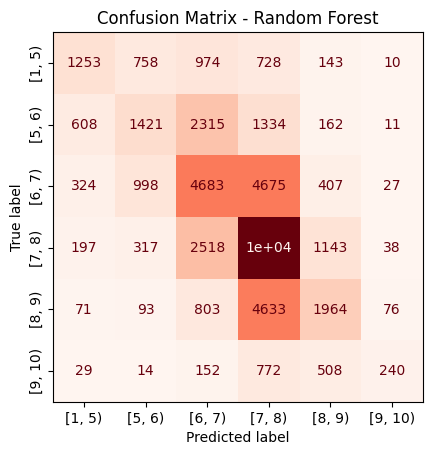

In [25]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ticks = [
    '[1, 5)',
    '[5, 6)',
    '[6, 7)',
    '[7, 8)',
    '[8, 9)',
    '[9, 10)'
]

# Predict on the test set
y_pred = best_model_rf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))


plt.figure(figsize=(4, 4))
disp = ConfusionMatrixDisplay.from_estimator(best_model_rf, X_test, y_test, cmap='Reds', xticks_rotation=45,
                                             colorbar=False)
disp.ax_.set_xticklabels(ticks, rotation=0)
disp.ax_.set_yticklabels(ticks, rotation=90, va='center')

plt.title('Confusion Matrix - Random Forest')
plt.show()

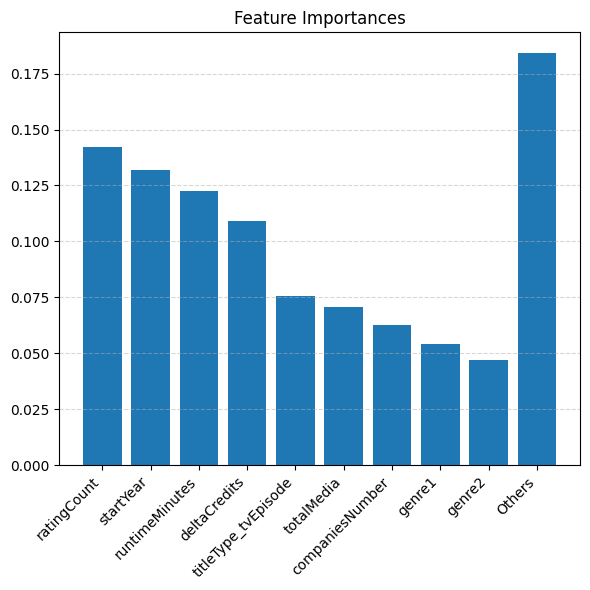

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare top 9 features and sum of the rest
top_n = 9
top_indices = np.argsort(best_model_rf.feature_importances_)[::-1][:top_n]
rest_importance = best_model_rf.feature_importances_[np.argsort(best_model_rf.feature_importances_)[::-1][top_n:]].sum()
plot_importances = np.concatenate([best_model_rf.feature_importances_[top_indices], [rest_importance]])
plot_names = list(scaler.get_feature_names_out()[top_indices]) + ['Others']

# Plot the feature importances
plt.figure(figsize=(6, 6))
plt.title("Feature Importances")
plt.bar(range(len(plot_importances)), plot_importances, align='center')
# Get column names from scaler
column_names = scaler.get_feature_names_out()
# Sort column names according to indices
column_names = np.array(column_names)[top_indices].tolist() + ['Others']

plt.xticks(range(len(plot_importances)), plot_names, rotation=45, ha='right')
# plt.xlim([-1, X_train.shape[1]])
plt.grid(alpha=0.5, linestyle='--', axis='y')
plt.tight_layout()
plt.show()

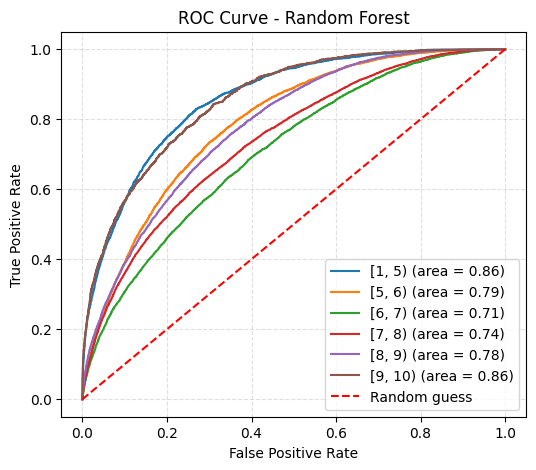

In [27]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve for each rating bin
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(ticks)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, best_model_rf.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(6, 5))
for i in range(len(ticks)):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(ticks[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.title('ROC Curve - Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(linestyle='--', alpha=0.4)
plt.show()

# Boosting

In [49]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from scipy.stats import uniform, randint

# Define the search space for hyperparameters
search_map_ab = {
    'n_estimators': randint(10, 100),
    'learning_rate': uniform(0.01, 1.0),
    'estimator__max_depth': randint(1, 20),
    'estimator__min_samples_split': randint(2, 20),
    'estimator__min_samples_leaf': randint(1, 20),
}

# Define the AdaBoost model
boosting_model = AdaBoostClassifier(random_state=42)

# Define the cross-validation strategy
cv_rf = StratifiedKFold(
    n_splits=5
)

In [ ]:
# Randomized search
random_search_ab = RandomizedSearchCV(
    estimator=search_model_ab,
    param_distributions=search_map_ab,
    n_iter=200,
    scoring='accuracy',
    cv=cv_ab,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_ab.fit(X_train, y_train)
best_model_ab = random_search_ab.best_estimator_
print("Best parameters found for Random Forest:", random_search_ab.best_params_)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

In [ ]:
# train the adaboost model using the best parameters
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

best_params = {'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 2, 'learning_rate': 0.6520316461542878, 'n_estimators': 84}
best_model_ab = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        # max_depth=best_params['estimator__max_depth'],
        min_samples_leaf=best_params['estimator__min_samples_leaf'],
        min_samples_split=best_params['estimator__min_samples_split'],
        random_state=42
    ),
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    random_state=42
)
best_model_ab.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(min_samples_leaf=3,
                                                    random_state=42),
                   learning_rate=0.6520316461542878, n_estimators=84,
                   random_state=42)

In [ ]:
# Classification report
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Predict on the test set
y_pred = best_model_ab.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.30      0.39      3866
           1       0.41      0.25      0.31      5851
           2       0.41      0.46      0.43     11114
           3       0.47      0.67      0.55     14674
           4       0.48      0.31      0.38      7640
           5       0.66      0.18      0.29      1715

    accuracy                           0.45     44860
   macro avg       0.50      0.36      0.39     44860
weighted avg       0.46      0.45      0.44     44860



<Figure size 400x400 with 0 Axes>

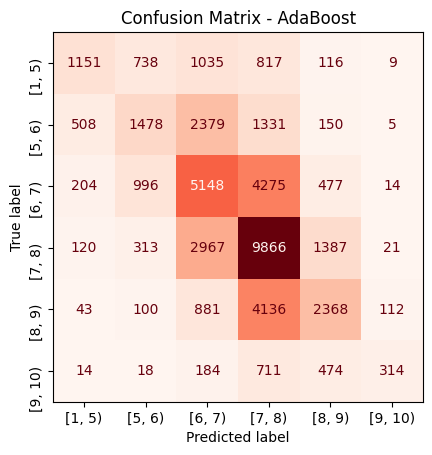

In [ ]:
plt.figure(figsize=(4, 4))
disp = ConfusionMatrixDisplay.from_estimator(best_model_ab, X_test, y_test, cmap='Reds', xticks_rotation=45,
                                             colorbar=False)

disp.ax_.set_xticklabels(ticks, rotation=0)
disp.ax_.set_yticklabels(ticks, rotation=90)
plt.title('Confusion Matrix - AdaBoost')
plt.show()

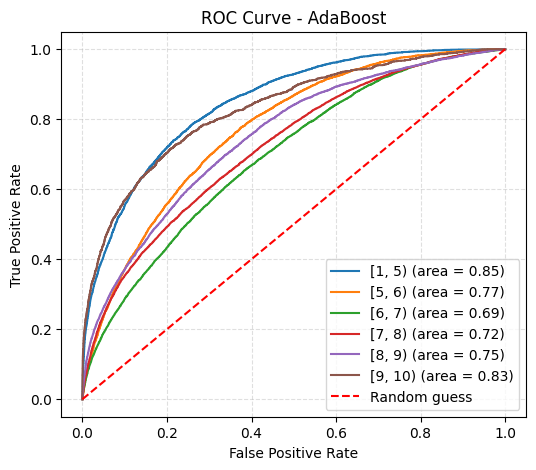

In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve for each rating bin
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(ticks)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, best_model_ab.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(6, 5))
for i in range(len(ticks)):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(ticks[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.title('ROC Curve - AdaBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(linestyle='--', alpha=0.4)
plt.show()

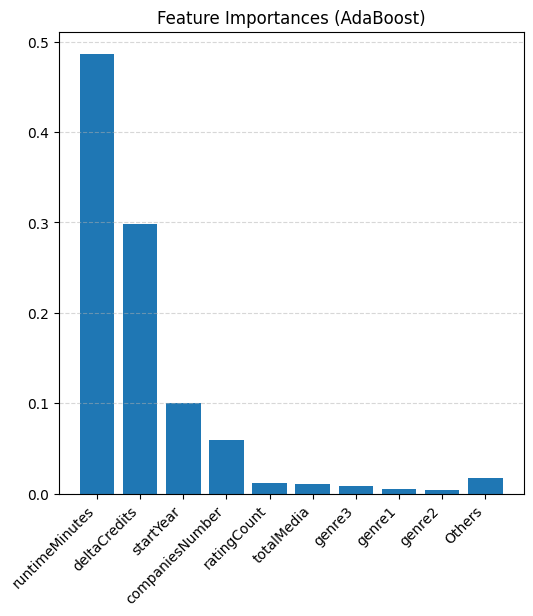

In [ ]:
# Feature importances for AdaBoost
# Get feature importances from the best_model_ab
importances_ab = best_model_ab.feature_importances_
indices_ab = np.argsort(importances_ab)[::-1]
# select top 9 features and sum the rest
top_n = 9
top_indices_ab = indices_ab[:top_n]
rest_importance_ab = importances_ab[indices_ab[top_n:]].sum()
importances_ab = np.concatenate([importances_ab[top_indices_ab], [rest_importance_ab]])
# Plot names
plot_names_ab = list(scaler.get_feature_names_out()[top_indices_ab]) + ['Others']

# plot the feature importances
plt.figure(figsize=(6, 6))
plt.title("Feature Importances (AdaBoost)")
plt.bar(range(len(importances_ab)), importances_ab, align='center')
# change to get_feature_names_out
# Get column names from scaler
column_names_ab = scaler.get_feature_names_out()
# Sort column names according to indices
column_names_ab = np.array(column_names_ab)[top_indices_ab].tolist() + ['Others']
plt.xticks(range(len(importances_ab)), plot_names_ab, rotation=45, ha='right')
plt.grid(alpha=0.5, linestyle='--', axis='y')
plt.show()